## High dimensional systems

In the previous notebook, we fit an LDS with only two latent variables. What happens if our data are higher dimensional? How do we visualize it and understand the behavior of the system?

In [190]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)
import helpers

import ssm
from ssm.util import random_rotation
from ssm.plots import plot_dynamics_2d
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
save_figures = False
%matplotlib inline

## 1. Stability analysis via a flow field plot
As you have seen before, we can plot trajectories through state space, we can also describe the behavior of the system anywhere in the state space with a flow field or vector field. This gives us a nice overview of how the system behaves, but it's really only useful for low-dimensional systems.

Let's create a 2D system with a saddle point (stable along one axis, unstable along another)

In [191]:
time_bins = 200   # number of time bins
state_dim = 2     # number of latent dimensions
obs_dim = 100      # number of observed dimensions, now 100

stable_dims = np.array([0])  # which latent dimensions are stable, the rest are unstable

In [192]:
# Make an LDS with somewhat interesting dynamics parameters
true_lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian_orthog")

# create a dynamics matrix with both stable and unstable dimensions (a saddle point)
A, _ = helpers.make_stable_LDS_matrix(state_dim, stable_dims, stability_strength=.5, random_axes=True)
b = npr.randn(state_dim)
#b = np.zeros(state_dim)  # no bias

# Set the dynamics matrix (A) and the 
true_lds.dynamics.A = A
true_lds.dynamics.b = b

# Sample from the LDS object.
states, emissions = true_lds.sample(time_bins, with_noise=False)

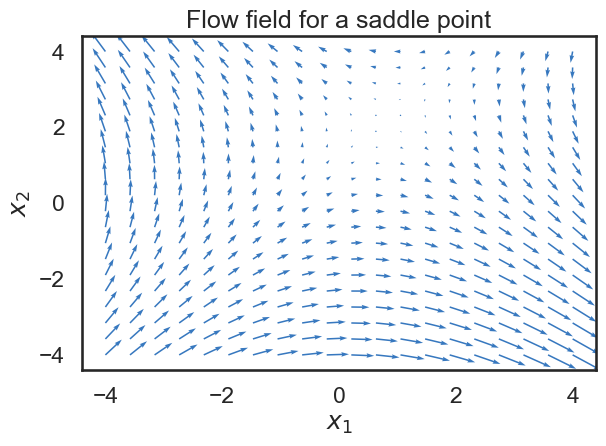

In [193]:
# plotting
minv, maxv = -4, 4

# Plot the dynamics vector field
q = plot_dynamics_2d(A, 
                     bias_vector=b,
                     mins=(minv,minv),
                     maxs=(maxv,maxv),
                     color=colors[0])

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Flow field for a saddle point")
plt.tight_layout()

## 2. Stability analysis of high-dimensional systems
You may notice in the plot above that the system is stable along `stable_dims` and unstable for the other dimension. Stability analysis via flow fields becomes much more difficult for high-dimensional systems. We simply cannot visualize this. Fortunately we have a few tricks when this is the case.

Let's first create a new dynamical system with 6 dimensions.

In [194]:
time_bins = 200   # number of time bins
state_dim = 6     # number of latent dimensions, now 6 
obs_dim = 100      # number of observed dimensions, now 100

stable_dims = np.array([3,5])  # which latent dimensions are stable, the rest are unstable
#stable_dims = np.array([])  

true_lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian_orthog")
A, _ = helpers.make_stable_LDS_matrix(state_dim, stable_dims, stability_strength=.5, random_axes=True)
b = npr.randn(state_dim)
#b = np.zeros(state_dim)

# Set the dynamics matrix (A) and the 
true_lds.dynamics.A = A
true_lds.dynamics.b = b

### Find the fixed points
Remember, this is where $x_{t+1} = x_t$

We also know $x_{t+1} = Ax_t + b$ (you may have noticed we dropped the input matrix $V$ since we don't have any inputs here)

We can set $x_t$ equal to $x_{t+1}$ and solve:

$$
x^* = (I - A)^{-1}b
$$

In [195]:
x_star = np.linalg.inv(np.eye(state_dim) - A) @ b
print(x_star)
assert np.allclose(A @ x_star + b, x_star) # check it's a fixed point

[-0.1785251  -0.19381636 -0.72141713  0.05025662  0.42427047 -0.59303211]


This is a quick an dirty way to solve, but we did find one fixed point. We also verified that we could plug it back in and $x_{t+1}$ is unchanged.

### Determining stability of fixed points

In [196]:
ev, eg = np.linalg.eig(A)
stable_axes = np.where(np.abs(ev) < 1)[0]
stable_directions = eg[:, stable_axes]
stable_directions

array([[ 0.41481521, -0.17549192],
       [-0.30968814,  0.15399599],
       [-0.62599974, -0.67769392],
       [-0.02230429,  0.46899744],
       [ 0.28474518, -0.14637981],
       [-0.50849644,  0.49480615]])

In [197]:
eigvals, eigvecs = np.linalg.eig(A)
abs_less_than_one = np.abs(eigvals) < 1
print(f'The stable eigenvalues are: {eigvals[abs_less_than_one]}')
stable_eigenvecs = eigvecs[:, abs_less_than_one]
print(f'The stable directions (eigenvectors) are:\n {stable_eigenvecs}')


The stable eigenvalues are: [0.37326464 0.12313731]
The stable directions (eigenvectors) are:
 [[ 0.41481521 -0.17549192]
 [-0.30968814  0.15399599]
 [-0.62599974 -0.67769392]
 [-0.02230429  0.46899744]
 [ 0.28474518 -0.14637981]
 [-0.50849644  0.49480615]]


### Oscillatory dynamics

Lets create a system where there are now rotational dynamics. We already did this earlier, but we will increase the number of dimensions now and analyze its behavior.

In [198]:
A = .99 * random_rotation(state_dim, theta=np.pi/20)

eigvals, eigvecs = np.linalg.eig(A)
eigvals

array([0.97781146+0.15487012j, 0.97781146-0.15487012j,
       0.99      +0.j        , 0.99      +0.j        ,
       0.99      +0.j        , 0.99      +0.j        ])

In [199]:
# the eigenvalues are now complex. This implies oscillation.
# look first at the real part to determine stability
print(np.real(eigvals))

# then look at the imaginary parts to see which eigenvalues are oscillatory
print(np.imag(eigvals))
# from this we could also compute the oscillation frequency and damping, but we will save this for another notebook

[0.97781146 0.97781146 0.99       0.99       0.99       0.99      ]
[ 0.15487012 -0.15487012  0.          0.          0.          0.        ]
